In [1]:
from platform import python_version
print(python_version())

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
77596,00019078_000.png,Infiltration,0,19078,16,M,PA,2790,2991,0.143,0.143,NaN,../data/images_009/images/00019078_000.png
67143,00016587_045.png,No Finding,45,16587,46,F,AP,2500,2048,0.168,0.168,NaN,../data/images_008/images/00016587_045.png
65319,00016134_003.png,No Finding,3,16134,43,M,AP,2500,2048,0.168,0.168,NaN,../data/images_008/images/00016134_003.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                                        54652
Infiltration                                                                                       8734
Atelectasis                                                                                        3848
Effusion                                                                                           3659
Nodule                                                                                             2495
Mass                                                                                               2015
Pneumothorax                                                                                       1972
Effusion|Infiltration                                                                              1511
Atelectasis|Infiltration                                                                           1237
Consolidation                                                   

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

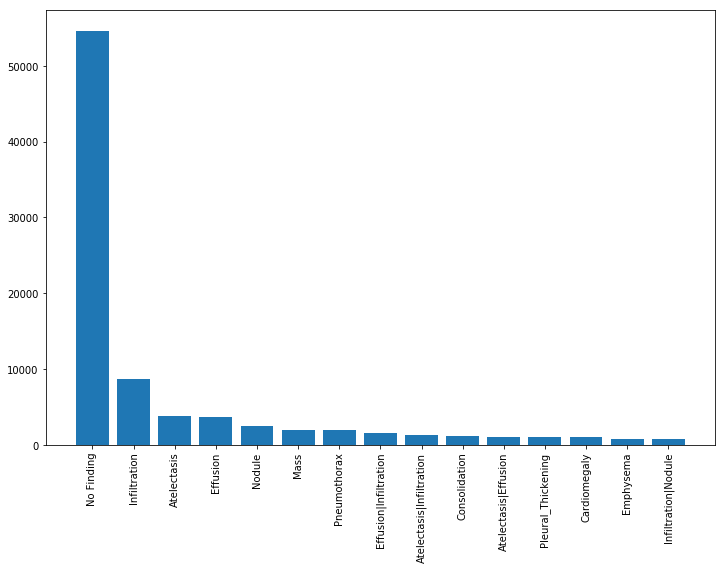

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
15235,00003996_006.png,No Finding,6,3996,44,M,PA,2894,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
77877,00019124_110.png,Pneumothorax,110,19124,51,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30588,00007998_000.png,Mass,0,7998,29,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [10]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [11]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
68599,00016937_001.png,Nodule|Pneumothorax,1,16937,54,F,PA,2546,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50096,00012678_000.png,No Finding,0,12678,52,M,PA,2802,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
68266,00016841_006.png,No Finding,6,16841,52,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
print(arrivals)

Atelectasis: 0.104485
Cardiomegaly: 0.024246
Consolidation: 0.041823
Edema: 0.021054
Effusion: 0.121524
Emphysema: 0.022474
Fibrosis: 0.013778
Infiltration: 0.179113
Mass: 0.053408
No Finding: 0.535174
Nodule: 0.057648
Pleural_Thickening: 0.029965
Pneumonia: 0.012691
Pneumothorax: 0.047611
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]


In [13]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


# Label the type of each image and create a training data-set that is balanced across all image types


In [14]:
def image_type(X):
    if any(item =='Pneumothorax' for item in X):
        return 1
    elif any(item =='Emphysema' for item in X):
        return 2
    elif any(item =='Pneumonia' for item in X):
        return 3
    elif any(item =='Edema' for item in X):
        return 4
    elif any(item =='Consolidation' for item in X):
        return 5
    elif any(item =='Effusion' for item in X):
        return 6
    elif any(item =='Infiltration' for item in X):
        return 7
    elif any(item =='Atelectasis' for item in X):
        return 8
    elif any(item =='Cardiomegaly' for item in X):
        return 9
    elif any(item =='Pleural_Thickening' for item in X):
        return 10
    elif any(item =='Fibrosis' for item in X):
        return 11
    elif any(item =='Mass' for item in X):
        return 12
    elif any(item =='Nodule' for item in X):
        return 13
    else:
        return 14
def rank_disease(item):
    if item =='Pneumothorax':
        return 1
    elif item =='Emphysema':
        return 2
    elif item =='Pneumonia':
        return 3
    elif item =='Edema':
        return 4
    elif item =='Consolidation':
        return 5
    elif item =='Effusion':
        return 6
    elif item =='Infiltration':
        return 7
    elif item =='Atelectasis':
        return 8
    elif item =='Cardiomegaly':
        return 9
    elif item =='Pleural_Thickening':
        return 10
    elif item =='Fibrosis':
        return 11
    elif item =='Mass':
        return 12
    elif item =='Nodule':
        return 13
    else:
        return 14

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [15]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
from itertools import chain
all_xray_df['Type']=all_xray_df['Finding Labels'].map(lambda x: image_type(x.split('|')))

In [16]:
print(all_xray_df[['Type','Finding Labels']].sample(10))


        Type                          Finding Labels
28180      3                  Infiltration|Pneumonia
33444      6                                Effusion
107693     2            Consolidation|Emphysema|Mass
83448      5  Atelectasis|Consolidation|Infiltration
58773      2      Atelectasis|Emphysema|Infiltration
50967     14                              No Finding
40149     14                              No Finding
105490     6                   Cardiomegaly|Effusion
69022      5             Consolidation|Effusion|Mass
35588     14                              No Finding


In [17]:
print(all_xray_df['Type'].value_counts())

14    54740
7     12078
6      9474
1      4862
8      4577
5      3758
13     2501
12     2410
4      1793
2      1602
10     1360
3      1243
9      1043
11      679
Name: Type, dtype: int64


In [18]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


In [19]:
from sklearn.model_selection import train_test_split
train_df, valid_test_df = train_test_split(all_xray_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Type'])

In [20]:
valid_df, test_df = train_test_split(valid_test_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = valid_test_df['Type'])

In [21]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (51060, 30) validation (25530, 30) test (25530, 30)


In [22]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelT'] = train_df['Type']
print(train_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
11118  00002879_000.png     No Finding            0        2879           59   
91671  00022859_000.png     No Finding            0       22859           45   
78754  00019327_000.png    Atelectasis            0       19327           48   

      Patient Gender View Position  OriginalImage[Width  Height]  \
11118              M            PA                 2802     2991   
91671              M            PA                 2992     2991   
78754              M            PA                 2730     2991   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
11118                        0.143  ...   0.0         1.0    0.0   
91671                        0.143  ...   0.0         1.0    0.0   
78754                        0.143  ...   0.0         0.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
11118                 0.0        0.0           0.0   
91671                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelT'] = valid_df['Type']
print(valid_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
81707  00020095_001.png         Nodule            1       20095           62   
80293  00019731_000.png         Nodule            0       19731           75   
20912  00005579_006.png   Infiltration            6        5579           56   

      Patient Gender View Position  OriginalImage[Width  Height]  \
81707              M            AP                 3056     2544   
80293              F            PA                 2992     2991   
20912              F            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
81707                        0.139  ...   0.0         0.0    1.0   
80293                        0.143  ...   0.0         0.0    1.0   
20912                        0.168  ...   0.0         0.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
81707                 0.0        0.0           0.0   
80293                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelT'] = test_df['Type']
print(test_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
53055  00013383_000.png  Effusion|Mass            0       13383           41   
17326  00004651_003.png     No Finding            3        4651           22   
31281  00008158_000.png         Nodule            0        8158           53   

      Patient Gender View Position  OriginalImage[Width  Height]  \
53055              F            PA                 2742     2885   
17326              M            PA                 2048     2500   
31281              F            PA                 2048     2500   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
53055                        0.143  ...   1.0         0.0    0.0   
17326                        0.171  ...   0.0         1.0    0.0   
31281                        0.168  ...   0.0         0.0    1.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
53055                 0.0        0.0           0.0   
17326                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AxesSubplot(0.125,0.125;0.775x0.755)


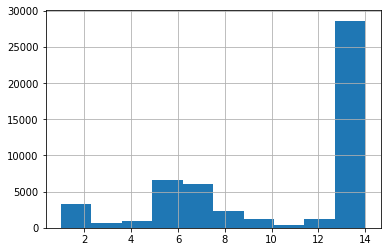

In [25]:
print(train_df['Type'].hist())

In [26]:
#from imblearn.over_sampling import SMOTE

In [27]:
#pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [28]:
from sklearn.preprocessing import LabelEncoder
y=train_df['Type']

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(train_df, y)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


In [30]:
X_res.shape

(383180, 32)

In [31]:
train_df.shape

(51060, 32)

AxesSubplot(0.125,0.125;0.775x0.755)


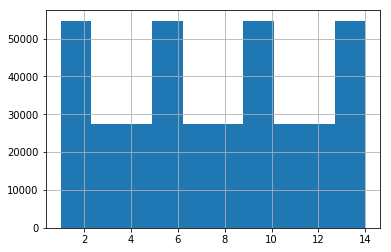

In [32]:
train_df=X_res
print(train_df['Type'].hist())

# Training the Model

In [33]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [34]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

In [35]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [36]:
n_priorities=4

In [37]:
def image_type_vector(X):
    set=X
    pet=set[set==1].index.tolist()
    return(image_type([all_labels[i] for i in pet]))

In [38]:
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

# Sample a test set, generate the predictions from sequential triage model

In [39]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

In [40]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

In [41]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100     

In [148]:
import gc
gc.collect()
import tensorflow as tf
tf.keras.backend.clear_session()
types=14
queues=4
class_labels=[str(X) for X in range(1,types+1)]
multi_disease_model = MakeModel1(imageSize, batchSize, channels)
multi_disease_model.load_weights("xray_class_weights.best.sequential.january_2022.hdf5")
test_df['Type']=test_df['Type'].astype(str)
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Type', 
                             class_mode = 'categorical',
                            classes = class_labels,
                            target_size = imageSize,
                             color_mode = colorMode,
                            batch_size = 2000))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Found 25530 validated image filenames belonging to 14 classes.


In [43]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 1, verbose = True)

2000/2000 [==============================] - 29s 13ms/step


In [149]:
del multi_disease_model

# Generate the Q matrix for sequential triage and compute the minimum waiting cost matrix for r=1.8, rho=0.9

In [150]:
import pickle
f=open('data_disease_thresholds.pkl', 'rb') 
Youden_Thresholds = pickle.load(f)
f.close()

In [151]:
set=Youden_Thresholds.values()

In [152]:
set=Youden_Thresholds.values()
set=np.array(np.round_(list(set),2))
set=pd.DataFrame(set)
set=pd.DataFrame(set.T)
set=pd.concat([set]*test_Y.shape[0])


In [153]:
#types=14
#queues=4
#set=[0.2]*types
#set=np.array(list(set))
#set=pd.DataFrame(set)
#set=pd.DataFrame(set.T)
#set=pd.concat([set]*test_Y.shape[0])

In [154]:
def image_type_vector(X):
    set=X
    pet=set[set==1].index.tolist()
    return(image_type([all_labels[i] for i in pet]))

In [156]:
test_Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [169]:

data2=(1+np.sign(pred_Y-set))/2

In [171]:
data2.shape

(2000, 14)

In [172]:
data2=pd.DataFrame(data2).apply(lambda row : image_type_vector(row), axis = 1)
data2.index=range(test_Y.shape[0])

In [173]:
data2

0       10
1        3
2       10
3        9
4        1
5       10
6       10
7        3
8        1
9       10
10       3
11       3
12       1
13       3
14      12
15       9
16       3
17       3
18      11
19       3
20       3
21       1
22       1
23       1
24       3
25       3
26      10
27       9
28       1
29       3
        ..
1970     1
1971    13
1972     3
1973     3
1974     3
1975     3
1976     3
1977    10
1978     1
1979     3
1980     3
1981     3
1982    11
1983     2
1984     3
1985     3
1986     9
1987     9
1988     3
1989     3
1990     3
1991    10
1992     3
1993     3
1994     9
1995     3
1996     5
1997     3
1998     1
1999     3
Length: 2000, dtype: int64

In [180]:
from sklearn.preprocessing import OneHotEncoder
a = [[i] for i in range(1,types+1)]
enc = OneHotEncoder()
enc.fit_transform(a)

<14x14 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [181]:
pred_Y_type=enc.transform(np.array(data2).reshape(-1,1)).todense()
pred_Y_type.shape

(2000, 14)

In [185]:
pred_Y_type.shape

(2000, 14)

In [186]:
test_Y.shape

(2000, 14)

In [187]:
mat1=np.matmul(np.transpose(test_Y),pred_Y_type)
Q_Youden=pd.DataFrame(mat1/mat1.sum(axis=1).reshape(-1,1))

In [188]:
Q_Youden

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.246914,0.037037,0.432099,0.0,0.024691,0.000000,0.0,0.012346,0.123457,0.098765,0.012346,0.012346,0.000000,0.000000
1,0.160000,0.040000,0.440000,0.0,0.000000,0.000000,0.0,0.040000,0.080000,0.120000,0.000000,0.080000,0.040000,0.000000
2,0.250000,0.062500,0.500000,0.0,0.000000,0.000000,0.0,0.062500,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000
3,0.277778,0.074074,0.388889,0.0,0.000000,0.000000,0.0,0.000000,0.018519,0.203704,0.018519,0.000000,0.018519,0.000000
4,0.333333,0.047619,0.309524,0.0,0.000000,0.000000,0.0,0.023810,0.095238,0.142857,0.023810,0.023810,0.000000,0.000000
5,0.193727,0.035055,0.436347,0.0,0.005535,0.002768,0.0,0.016605,0.067343,0.167897,0.024908,0.015683,0.033210,0.000923
6,0.292683,0.000000,0.341463,0.0,0.024390,0.000000,0.0,0.024390,0.121951,0.073171,0.048780,0.000000,0.073171,0.000000
7,0.142857,0.047619,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.095238,0.333333,0.047619,0.000000,0.000000,0.000000
8,0.205128,0.051282,0.487179,0.0,0.000000,0.000000,0.0,0.000000,0.025641,0.230769,0.000000,0.000000,0.000000,0.000000
9,0.182927,0.060976,0.487805,0.0,0.000000,0.000000,0.0,0.024390,0.048780,0.158537,0.012195,0.000000,0.024390,0.000000


In [189]:
from itertools import combinations
types=14
queues=4

In [190]:
combination_lists=list(combinations(range(types-1),queues-1))

In [191]:
combination_lists

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (0, 1, 12),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 2, 10),
 (0, 2, 11),
 (0, 2, 12),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 3, 10),
 (0, 3, 11),
 (0, 3, 12),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 4, 10),
 (0, 4, 11),
 (0, 4, 12),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 5, 10),
 (0, 5, 11),
 (0, 5, 12),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 6, 10),
 (0, 6, 11),
 (0, 6, 12),
 (0, 7, 8),
 (0, 7, 9),
 (0, 7, 10),
 (0, 7, 11),
 (0, 7, 12),
 (0, 8, 9),
 (0, 8, 10),
 (0, 8, 11),
 (0, 8, 12),
 (0, 9, 10),
 (0, 9, 11),
 (0, 9, 12),
 (0, 10, 11),
 (0, 10, 12),
 (0, 11, 12),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 2, 7),
 (1, 2, 8),
 (1, 2, 9),
 (1, 2, 10),
 (1, 2, 11),
 (1, 2, 12),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 3, 7),
 (1,

In [192]:
mat=np. zeros((types,queues))
mat[0,1]

0.0

In [193]:
def partition_matrix(partition):
    mat=np.zeros((types,queues))
    for i in range(1,queues-1):
        for j in range((partition[i-1]+1),partition[i]+1):
                mat[j,i]=1
    for j in range(partition[0]+1):
        mat[j,0]=1
    for j in range(partition[queues-2]+1,types):
        mat[j,(queues-1)]=1
    return mat   

In [194]:
list_partition_matrices = list(map(partition_matrix, combination_lists))

In [195]:
list_partition_matrices[1]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [196]:
def get_pmat_q_youden(partition_matrix):
    return np.dot(Q_Youden,partition_matrix)
def get_pmat_q_point_five(partition_matrix):
    return np.dot(Q_point_five,partition_matrix)
def get_pmat_q_identity(partition_matrix):
    return np.dot(np.identity(types),partition_matrix)

In [197]:
def get_arrival_rates_types(data):
    types_test_data=pd.Series(data['Type'].value_counts().index)
    counts_types_test_data=pd.Series(data['Type'].value_counts())
    arrivals_types_test_data=counts_types_test_data/counts_types_test_data.sum(axis=0)
    return pd.DataFrame({'Type':types_test_data.values,'Arrival_Rates':arrivals_types_test_data.values}).sort_values('Type', ascending=True)['Arrival_Rates'].values   

In [198]:
def get_costs_types(r):
    return [r**(types-rank-1) for rank in range(types)]

In [199]:
def get_service_rates_types(rho):
    return [1/rho]*types

In [200]:
list_of_costs_different_partition_matrices=[queue_wait_cost(get_pmat_q_youden(X),get_costs_types(1.8),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.9)) for X in list_partition_matrices]

In [201]:
min_cost_sequential=np.min(list_of_costs_different_partition_matrices)
min_index=np.argmin(list_of_costs_different_partition_matrices)

In [202]:
print(min_cost_sequential)

1225.1165211263412


In [203]:
get_pmat_q_youden(list_partition_matrices[min_index])

array([[0.28395062, 0.59259259, 0.11111111, 0.01234568],
       [0.2       , 0.56      , 0.12      , 0.12      ],
       [0.3125    , 0.5625    , 0.125     , 0.        ],
       [0.35185185, 0.40740741, 0.22222222, 0.01851852],
       [0.38095238, 0.42857143, 0.16666667, 0.02380952],
       [0.22878229, 0.52859779, 0.19280443, 0.0498155 ],
       [0.29268293, 0.51219512, 0.12195122, 0.07317073],
       [0.19047619, 0.42857143, 0.38095238, 0.        ],
       [0.25641026, 0.51282051, 0.23076923, 0.        ],
       [0.24390244, 0.56097561, 0.17073171, 0.02439024],
       [0.15976331, 0.62130178, 0.19526627, 0.02366864],
       [0.25327511, 0.50218341, 0.22270742, 0.02183406],
       [0.13483146, 0.69662921, 0.14606742, 0.02247191],
       [0.25      , 0.53571429, 0.14285714, 0.07142857]])

# Get the pmat and cost under direct triage

In [204]:
test_Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [205]:
multi_disease_model_p = MakeModel1(imageSize, batchSize, channels)
multi_disease_model_p.add(Dense(queues, activation = 'softmax'))
multi_disease_model_p.load_weights("xray_class_weights.best.direct_r_1.8_rho_0.90.january_2022.hdf5")

In [206]:
pred_Y_direct = multi_disease_model_p.predict(test_X, batch_size = 1, verbose = True)

2000/2000 [==============================] - 27s 13ms/step


In [207]:
pred_Y_direct

array([[9.9855788e-06, 1.5601827e-05, 8.2528277e-04, 9.9914908e-01],
       [8.1099137e-07, 9.3266106e-04, 9.9602991e-01, 3.0365882e-03],
       [1.2322229e-06, 9.9862146e-01, 1.3768692e-03, 4.8830981e-07],
       ...,
       [5.1440048e-07, 9.9473625e-01, 5.2595926e-03, 3.6976733e-06],
       [4.9209814e-07, 9.9436826e-01, 5.6272238e-03, 4.0953369e-06],
       [9.9855697e-06, 1.5601812e-05, 8.2528120e-04, 9.9914908e-01]],
      dtype=float32)

In [208]:
pred_Y_direct = tf.one_hot(tf.argmax(np.array(pred_Y_direct),axis=1), depth = 4)

In [209]:
pmat=np.dot(np.transpose(test_Y),pred_Y_direct)

In [210]:
pred_Y_direct

<tf.Tensor: shape=(2000, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [213]:
pmat

array([[  0.,  61.,  16.,   4.],
       [  0.,  17.,   8.,   0.],
       [  0.,  15.,   0.,   1.],
       [  0.,  43.,   9.,   2.],
       [  0.,  28.,  14.,   0.],
       [  0., 658., 315., 111.],
       [  0.,  32.,   9.,   0.],
       [  0.,  15.,   4.,   2.],
       [  0.,  25.,   7.,   7.],
       [  0.,  63.,  15.,   4.],
       [  0., 118.,  40.,  11.],
       [  0., 148.,  56.,  25.],
       [  0.,  53.,  28.,   8.],
       [  0.,   5.,   4.,  19.]], dtype=float32)

In [214]:
pmat_direct_r_1_8_rho_0_9=pmat/pmat.sum(axis=1,keepdims=True)

In [215]:
type(pmat_direct_r_1_8_rho_0_9)

numpy.ndarray

In [216]:
type(get_pmat_q_youden(list_partition_matrices[min_index]))

numpy.ndarray

In [217]:
np.array(pmat_direct_r_1_8_rho_0_9)

array([[0.        , 0.75308645, 0.19753087, 0.04938272],
       [0.        , 0.68      , 0.32      , 0.        ],
       [0.        , 0.9375    , 0.        , 0.0625    ],
       [0.        , 0.7962963 , 0.16666667, 0.03703704],
       [0.        , 0.6666667 , 0.33333334, 0.        ],
       [0.        , 0.6070111 , 0.2905904 , 0.10239852],
       [0.        , 0.7804878 , 0.2195122 , 0.        ],
       [0.        , 0.71428573, 0.1904762 , 0.0952381 ],
       [0.        , 0.64102566, 0.17948718, 0.17948718],
       [0.        , 0.76829267, 0.18292683, 0.04878049],
       [0.        , 0.69822484, 0.2366864 , 0.06508876],
       [0.        , 0.6462882 , 0.24454148, 0.1091703 ],
       [0.        , 0.5955056 , 0.31460676, 0.08988764],
       [0.        , 0.17857143, 0.14285715, 0.6785714 ]], dtype=float32)

In [218]:
queue_wait_cost(np.array(pmat_direct_r_1_8_rho_0_9),get_costs_types(1.8),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.9))

472.5611056262567

In [219]:
queue_wait_cost(get_pmat_q_youden(list_partition_matrices[min_index]),get_costs_types(1.8),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.9))

1225.1165211263412

In [265]:
get_pmat_q_youden(list_partition_matrices[min_index])

array([[0.68085106, 0.17021277, 0.10638298, 0.04255319],
       [0.61290323, 0.19354839, 0.16129032, 0.03225806],
       [0.36842105, 0.52631579, 0.10526316, 0.        ],
       [0.38709677, 0.61290323, 0.        , 0.        ],
       [0.4025974 , 0.55844156, 0.03896104, 0.        ],
       [0.5497076 , 0.38596491, 0.04678363, 0.01754386],
       [0.30837004, 0.4185022 , 0.18502203, 0.08810573],
       [0.29787234, 0.4893617 , 0.12765957, 0.08510638],
       [0.03571429, 0.39285714, 0.57142857, 0.        ],
       [0.4137931 , 0.24137931, 0.24137931, 0.10344828],
       [0.29411765, 0.29411765, 0.29411765, 0.11764706],
       [0.24      , 0.36      , 0.26      , 0.14      ],
       [0.31372549, 0.31372549, 0.29411765, 0.07843137],
       [0.16188714, 0.41720629, 0.226642  , 0.19426457]])